In [1]:
import numpy as np
import dxchange
import libtike.cufft as pt
import tomocg as tm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from skimage.filters import sobel
from create_probe import create_probe
# Load phantom
volume = -dxchange.read_tiff('delta-chip-256.tiff') + 1j*dxchange.read_tiff('beta-chip-256.tiff')
vol_size = volume.shape[0]
# volume = np.resize(volume,(vol_size,vol_size,vol_size))
h = volume.shape[1]
v = volume.shape[0]
[x,z,y]= np.meshgrid(np.arange(-h/2,h/2)/h*2,np.arange(-v/2,v/2)/v*2,np.arange(-h/2,h/2)/h*2)
cylinder=(x)**2+(y)**2<0.35
volume = volume*cylinder #make cylindrical shape
del cylinder
# Define tomography parameters
ntheta = 384#np.int(h*3/2)  # number of projections
theta = np.linspace(0,np.pi,ntheta).astype('float32')
# Define ptychography parameters
nx = 64 # number of scanning positions in x-axis
ny = 64 # number of scanning positions in y-axis
nscan = nx*ny  # total number of scanning positions
nprb = 128  # probe size
ndetx = 128  # detector x size
ndety = 128  # detector y size
# Volume zero padding
offset = 0 #extra padding for scan position misalignment
vol_pad = 64+offset
n = h+2*vol_pad  # horizontal size
nz = v+2*vol_pad # vertical size
volume = np.pad(volume,[(vol_pad,vol_pad),(vol_pad,vol_pad),(vol_pad,vol_pad)],mode='constant')

In [2]:
prb = np.zeros([ntheta,nprb,nprb],dtype='complex64')
probe_size = (24,24)
probe_pad = (nprb-probe_size[1])//2
prb[0] = np.pad(create_probe(probe_size),[(probe_pad,probe_pad),(probe_pad,probe_pad)],mode='constant')
for i in range(ntheta):
    prb[i] = prb[0]

In [3]:
# make probe positions (regular grid)
[X,Y]=np.meshgrid(np.linspace(offset, n-nprb-offset, ny), np.linspace(offset, nz-nprb-offset, nx))
scan = np.zeros([2,ntheta,nx*ny],dtype='float32')
for i in range(ntheta):
    scan[0,i] = X.flatten()
    scan[1,i] = Y.flatten()

In [4]:
# Generate/Load diffraction data
with tm.SolverTomo(theta, ntheta, nz, n, 32, n//2) as slv:
    psi = np.exp(1j*1000*slv.fwd_tomo_batch(volume))

In [5]:
with pt.CGPtychoSolver(nscan, nprb, ndetx, ndety, ntheta, nz, n, ptheta=1, igpu=0) as ptslv:
    data = np.abs(ptslv.fwd_ptycho_batch(psi, scan, prb))**2

In [14]:
# for i in range(ntheta):
#     for j in range(nscan):
#         vals = 2 ** np.ceil(np.log2(len(np.unique(data[i,j]))))
#         data[i,j] = data[i,j] + np.random.poisson(data[i,j]*vals)/float(vals)

In [54]:
# for i in range(ntheta):
#     for j in range(nscan):
#         gauss = np.random.normal(loc=np.mean(data[i,j]), scale=np.std(data[i,j]), size=(data.shape[-1],data.shape[-2]))
#         data[i,j] = data[i,j] + gauss

<IPython.core.display.Javascript object>


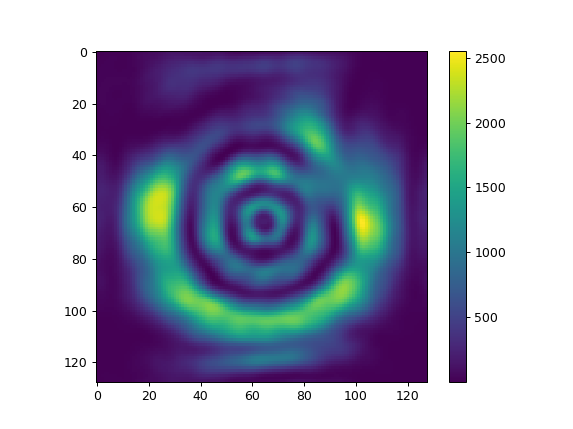

In [59]:
# %matplotlib notebook
# plt.figure()
# plt.imshow(np.fft.fftshift(data[0,745]))
# plt.colorbar()

# Differential Phase Map with regular grid

In [ ]:
phase_h = np.zeros(data.shape)
phase_v = np.zeros(data.shape)
stxm_h = np.zeros((scan.shape[1],scan.shape[2]))
stxm_v = np.zeros((scan.shape[1],scan.shape[2]))
upsample_factor = 4
phase_map = np.zeros((scan.shape[1],nx*upsample_factor,ny*upsample_factor))
for i in range(scan.shape[1]):
    for j in range(scan.shape[2]):
        a = np.sum(data[i,j,0:data.shape[-2]//2,:])
        b = np.sum(data[i,j,data.shape[-1]//2::,:])
        c = np.sum(data[i,j,:,0:data.shape[-2]//2])
        d = np.sum(data[i,j,:,data.shape[-1]//2::])
        phase_h[i,j] = (a-b)/(a+b+1e-15)
        phase_v[i,j] = (c-d)/(c+d+1e-15)
    stxm_h[i] = np.sum(np.sum(phase_h[i],-1),-1)
    stxm_v[i] = np.sum(np.sum(phase_v[i],-1),-1)
    stxm_amp = np.sqrt((stxm_h[i]-np.mean(stxm_h[i]))**2+(stxm_v[i]-np.mean(stxm_v[i]))**2)
    stxm_map = np.reshape(stxm_amp,(nx,ny))
    phase_map[i] = stxm_map.repeat(upsample_factor, axis=0).repeat(upsample_factor, axis=1)
# psi_edge = sobel(np.abs(psi[0][vol_pad:-vol_pad,vol_pad:-vol_pad]))
# psi_edge = resize(psi_edge, (psi_edge.shape[0]/1, psi_edge.shape[1]/1), anti_aliasing=True)

In [7]:
np.random.seed(0)
shift = np.random.randint(0,10,(2,ntheta))
phase_map_shift = phase_map.copy()
for i in range(ntheta):
    phase_map_shift[i] = np.roll(phase_map[i], shift[:,i], axis=(0,1))

In [ ]:
np.save('phase_grad_shifted_prb_24.npy',phase_map)

In [8]:
from skimage.feature import register_translation
shift_estim = np.zeros([2,scan.shape[1]])
for i in range(1,scan.shape[1]):
    shift_estim[:,i] = register_translation(phase_map[i-1,:], phase_map[i], 1000, return_error=False)
print(shift[:,1])
print(shift_estim[:,1])

[0 0]
[-0.001  0.002]


In [10]:
np.save('data.sim',data)
np.save('scan.sim',scan)